In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
traindata_7 = pd.read_csv("./traindata_7.csv")
traindata_14 = pd.read_csv("./traindata_14.csv")
sample_test = pd.read_csv("./sample_submission_2.csv")

In [3]:
# traindata_7= traindata_7[traindata_7["user_id_hash"].isin(sample_test["user_id_hash"])]
# traindata_14= traindata_14[traindata_14["user_id_hash"].isin(sample_test["user_id_hash"])]


In [4]:
# Imbalanced data - ratio of purchasers to non-purchasers
purch7 = len(traindata_7.target[traindata_7.target==0])/ len(traindata_7.target[traindata_7.target==1])
purch14 = len(traindata_14.target[traindata_14.target==0])/ len(traindata_14.target[traindata_14.target==1])
purch7, purch14

(153.98590143480973, 79.78376796514274)

# Model for 7 day prediction

## train, validation

In [5]:
# split data into X and y
X = traindata_7.drop(["target"], axis=1)
Y = traindata_7.target
# split data into train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

### Grid Search - bypass when not tuning hyperparameters

In [73]:
# fit model no training data
model_7 = XGBClassifier()

param_grid = {'learning_rate' : [0.1],
              'n_estimators' : [200],
              'max_depth' : [4],
              'min_child_weight' : [1],
              'scale_pos_weight' : [188],
              'colsample_bytree' : [0.9, 1]}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model_7, param_grid, scoring="log_loss", n_jobs=-1, cv=kfold)

grid_result = grid_search.fit(X.drop("user_id_hash", axis=1), Y)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f"mean: {m} (std: {s}) params: {p}")

Best: -0.1139028512330298 using {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 188}
mean: -0.11450893478341272 (std: 0.0013766568895601848) params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 188}
mean: -0.1139028512330298 (std: 0.0014233340749545509) params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 188}


### Use best hyperparameters from the above grid search

In [6]:
# fit model no training data
model_7 = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, scale_pos_weight=153)
model_7.fit(X_train.drop(["user_id_hash"], axis=1), y_train)
# make predictions for test data
y_pred = model_7.predict_proba(X_test.drop(["user_id_hash"], axis=1))[:,1]

# evaluate predictions
auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (auc * 100.0))

AUC: 98.78%


## Confusion Matrix

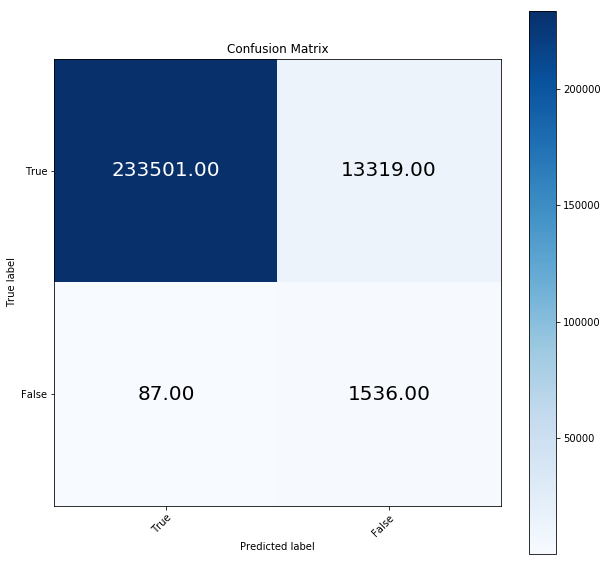

In [11]:
cmap=plt.cm.Blues
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred.round())
cm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['True', 'False'], yticklabels=['True', 'False'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

ax.figure.set_size_inches(10, 10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], '.2f'),
                fontsize=20,
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

In [14]:
y_test.value_counts()

0    246820
1      1623
Name: target, dtype: int64

### Feature Importance

In [ ]:
for col, imp in zip(X_train.drop(["user_id_hash"], axis=1).columns, model_7.feature_importances_):
    print(f"{col}: {imp}")

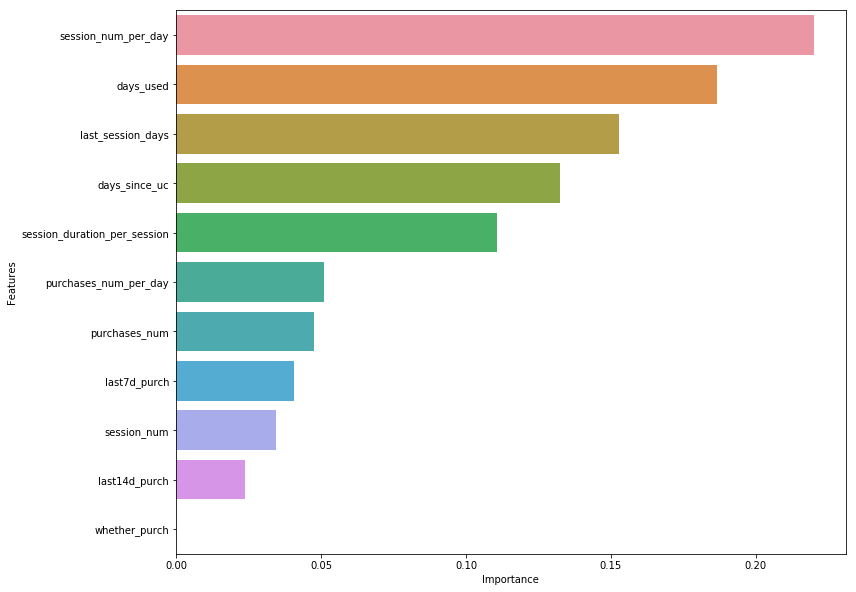

In [100]:
fi = pd.DataFrame({'Features' : X_train.drop(['user_id_hash'], axis=1).columns,
              'Importance' : model_7.feature_importances_})
fi.sort_values('Importance', ascending=False, inplace=True)

ax = sns.barplot(x="Importance", y="Features", data=fi)
ax.figure.set_size_inches(12, 10)

### Make prediction on features from entire dataset - for submission

In [52]:
allfeatures_7 = pd.read_csv("./allfeatures_7.csv")
df_features_7 = pd.merge(sample_test, allfeatures_7, how="left").drop(["user_purchase_binary_7_days",
                                                                   "user_purchase_binary_14_days",
                                                                   "user_id_hash"
                                                                  ], axis=1)
df_features_7

,days_since_uc,days_used,session_num,session_duration_per_session,last_session_days,purchases_num,whether_purch,last7d_purch,last14d_purch,purchases_num_per_day,session_num_per_day
0,49.0,1.0,2.0,3.565440e+05,49.0,0.0,0.0,0.0,0.0,0.000000,2.000000
1,24.0,2.0,1.0,0.000000e+00,24.0,0.0,0.0,0.0,0.0,0.000000,0.500000
2,48.0,3.0,4.0,3.886312e+05,40.0,0.0,0.0,0.0,0.0,0.000000,1.333333
3,51.0,4.0,10.0,9.200583e+06,32.0,0.0,0.0,0.0,0.0,0.000000,2.500000
4,64.0,2.0,1.0,0.000000e+00,64.0,0.0,0.0,0.0,0.0,0.000000,0.500000
5,60.0,2.0,1.0,0.000000e+00,60.0,0.0,0.0,0.0,0.0,0.000000,0.500000
6,34.0,2.0,1.0,0.000000e+00,34.0,0.0,0.0,0.0,0.0,0.000000,0.500000
7,69.0,1.0,1.0,0.000000e+00,69.0,0.0,0.0,0.0,0.0,0.000000,1.000000
8,67.0,1.0,1.0,0.000000e+00,67.0,0.0,0.0,0.0,0.0,0.000000,1.000000
9,37.0,1.0,1.0,0.000000e+00,37.0,0.0,0.0,0.0,0.0,0.000000,1.000000


In [53]:
model_7 = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.09, min_child_weight=1, scale_pos_weight=153)
model_7.fit(X.drop(["user_id_hash"], axis=1), Y)
y_pred_7 = model_7.predict_proba(df_features_7)[:,1]

# Model for 14 day prediction

In [ ]:
# split data into X and y
X = traindata_14.drop("target", axis=1)
Y = traindata_14.target
# split data into train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

### Grid Search - bypass when not tuning hyperparameters

In [24]:
# fit model no training data
model_14 = XGBClassifier()

param_grid = {'learning_rate' : [0.001, 0.01, 0.1, 0.2],
              'n_estimators' : [100],
              'max_depth' : [8],
              'min_child_weight' : [1, 3],
              'scale_pos_weight' : [100]}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model_14, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)

grid_result = grid_search.fit(X.drop("user_id_hash", axis=1), Y)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f"mean: {m} (std: {s}) params: {p}")

Best: 0.953621 using {'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 100}
0.953621 (0.003185) with: {'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 100}
0.952680 (0.003373) with: {'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 200}
0.947956 (0.003743) with: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
0.948578 (0.003336) with: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}
0.953140 (0.003431) with: {'learning_rate': 0.11, 'max_depth': 8, 'n_estimators': 100}
0.952354 (0.003500) with: {'learning_rate': 0.11, 'max_depth': 8, 'n_estimators': 200}


### Use best hyperparameters from the above grid search

In [ ]:
# fit model no training data
model_14 = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.09, min_child_weight=1, scale_pos_weight=79)
model_14.fit(X_train.drop(["user_id_hash"], axis=1), y_train)
# make predictions for test data
y_pred = model_14.predict_proba(X_test.drop(["user_id_hash"], axis=1))[:,1]

# evaluate predictions
auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (auc * 100.0))

## Confusion Matrix

In [ ]:
cmap=plt.cm.Blues
cm = confusion_matrix(y_test, y_pred.round())
cm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=['True', 'False'], yticklabels=['True', 'False'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

ax.figure.set_size_inches(10, 10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], '.2f'),
                size=20, ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

### Feature Importance

In [104]:
for col, imp in zip(X_train.drop(['user_id_hash'], axis=1).columns, model_14.feature_importances_):
    print(f"{col}: {imp}")

days_since_uc: 0.13281798362731934
days_used: 0.22276879847049713
session_num: 0.03162332996726036
session_duration_per_session: 0.04919184744358063
last_session_days: 0.11806043237447739
purchases_num: 0.0758959949016571
whether_purch: 0.0
last7d_purch: 0.04216444119811058
last14d_purch: 0.026001404970884323
purchases_num_per_day: 0.04848910868167877
session_num_per_day: 0.2529866397380829


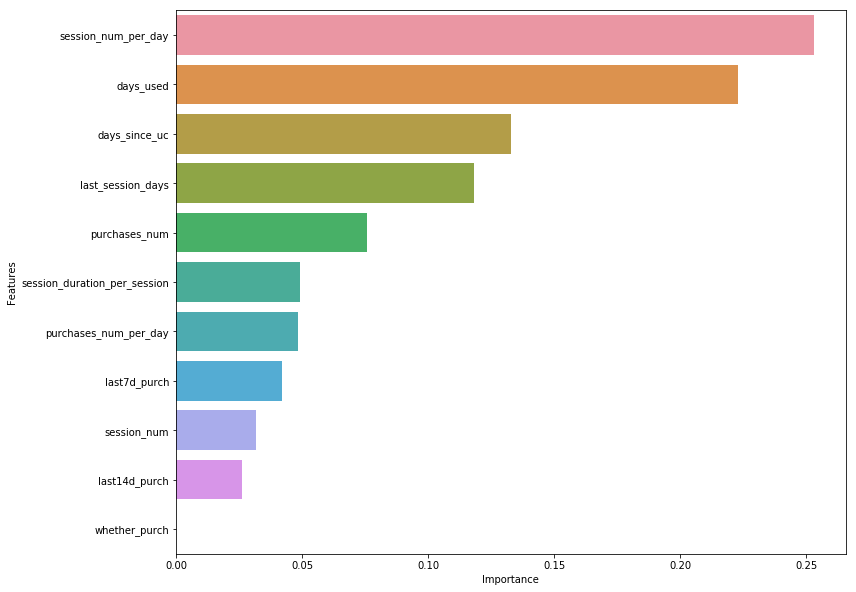

In [105]:
fi = pd.DataFrame({'Features' : X_train.drop(['user_id_hash'], axis=1).columns,
              'Importance' : model_14.feature_importances_})
fi.sort_values('Importance', ascending=False, inplace=True)

ax = sns.barplot(x="Importance", y="Features", data=fi)
ax.figure.set_size_inches(12, 10)

### Make prediction on features from entire dataset - for submission

In [58]:
allfeatures_14 = pd.read_csv("./allfeatures_14.csv")
df_features_14 = pd.merge(sample_test, allfeatures_14, how="left").drop(["user_purchase_binary_7_days",
                                                                   "user_purchase_binary_14_days",
                                                                   "user_id_hash"
                                                                  ], axis=1)
df_features_14

,days_since_uc,days_used,session_num,session_duration_per_session,last_session_days,purchases_num,whether_purch,last7d_purch,last14d_purch,purchases_num_per_day,session_num_per_day
0,49.0,1.0,2.0,3.565440e+05,49.0,0.0,0.0,0.0,0.0,0.000000,2.000000
1,24.0,2.0,1.0,0.000000e+00,24.0,0.0,0.0,0.0,0.0,0.000000,0.500000
2,48.0,3.0,4.0,3.886312e+05,40.0,0.0,0.0,0.0,0.0,0.000000,1.333333
3,51.0,4.0,10.0,9.200583e+06,32.0,0.0,0.0,0.0,0.0,0.000000,2.500000
4,64.0,2.0,1.0,0.000000e+00,64.0,0.0,0.0,0.0,0.0,0.000000,0.500000
5,60.0,2.0,1.0,0.000000e+00,60.0,0.0,0.0,0.0,0.0,0.000000,0.500000
6,34.0,2.0,1.0,0.000000e+00,34.0,0.0,0.0,0.0,0.0,0.000000,0.500000
7,69.0,1.0,1.0,0.000000e+00,69.0,0.0,0.0,0.0,0.0,0.000000,1.000000
8,67.0,1.0,1.0,0.000000e+00,67.0,0.0,0.0,0.0,0.0,0.000000,1.000000
9,37.0,1.0,1.0,0.000000e+00,37.0,0.0,0.0,0.0,0.0,0.000000,1.000000


In [59]:
model_14 = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.09, min_child_weight=1, scale_pos_weight=100)
model_14.fit(X.drop(["user_id_hash"], axis=1), Y)
y_pred_14 = model_14.predict_proba(df_features_14)[:,1]

# Write to prediction.csv

In [63]:
y_pred_14.shape, y_pred_7.shape

((312568,), (312568,))

In [71]:
sample_test["user_purchase_binary_7_days"] = y_pred_7

In [72]:
sample_test["user_purchase_binary_14_days"] = y_pred_14

In [73]:
sample_test.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.001917,0.003116
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.009595,0.007934
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.011962,0.018288
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.015070,0.015650
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.003808,0.004590


In [74]:
sample_test.to_csv("./prediction_v5.csv", index=False)

In [88]:
# only existent users
sample_test.to_csv("./prediction_v3.csv", index=False)

In [17]:
# all users
sample_test.to_csv("./prediction_v2.csv", index=False)

In [111]:
sample_test_prev = pd.read_csv("./prediction_v3.csv")

### Test Code to compare previous predictions

In [112]:
comp = pd.merge(sample_test, sample_test_prev, how='inner', on='user_id_hash')

In [117]:
comp[(comp.user_purchase_binary_7_days_x <  0.5) & (comp.user_purchase_binary_7_days_y >= 0.5)]

,user_id_hash,user_purchase_binary_7_days_x,user_purchase_binary_14_days_x,user_purchase_binary_7_days_y,user_purchase_binary_14_days_y
2797,506a1915fb4bd5bb63c3008514d6999c25d719844796a2...,0.437828,0.508676,0.661741,0.321743
6649,a5255b8c2a58d7597a6ebe18955b00b188ca56b55fc234...,0.323211,0.451415,0.662866,0.480323
9552,dcdf00d52bb7d624d6e0c4c64e23b0b6297ddb53e0ab63...,0.439321,0.624152,0.505314,0.484117
15433,d962f6073c3c509a8a30f9e3c57207f506e211b74beed4...,0.478981,0.455390,0.672604,0.263089
18331,e73fc545272e3bf38d6f7a9d4e4326d414bc177d10adcf...,0.404904,0.536413,0.620261,0.347713
25988,a35843d3fdbae8fe0ce3c79278a77a3c16819c72539131...,0.427684,0.832162,0.687885,0.456748
29727,9bcfc1549d616365c96ab726475f8a544df092d5b1663a...,0.402440,0.283799,0.551332,0.251158
31271,16cce29d3fca3bfffbc9fd713e78f78a26fd01503f3160...,0.398403,0.598166,0.515542,0.716952
33168,3c2d59a8bd5f5a8a19832489497cbfffdae8ddaead8502...,0.404621,0.366470,0.501838,0.249417
36192,bd8eebe5d90f83b6fc366f3f1f3a011088b1d25d479bc8...,0.436360,0.881400,0.650258,0.706300


### Looking at False Negatives

In [ ]:
# preds = model_14.predict(X_test.drop(['user_id_hash','pred'], axis=1))
# X_test['preds'] = preds
# X_test['true'] = y_test
X_test.loc[(X_test.preds != X_test.true) & (X_test.preds == 0), 'user_id_hash'].to_frame().to_csv("./false_negs.csv", index=False)
# pd.Series().to_frame().join(pd.Series(y_test).to_frame(), how='inner', lsuffix='1')
# pred